In [479]:
import numpy as np
from scipy.stats import norm
import scipy.linalg as LA
import scipy.optimize as opt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
import pandas as pd

In [480]:
np.random.seed(42)

def f1(x):
    # return np.exp(-0.5 * (x - np.pi)**2)
    return 0.2 * x**2 - x + 1.5
    # return np.tanh(x)
    # return np.log(x + 1)

def f2(x):
    return np.sin(2 * np.pi * x)

X_train = np.sort(np.random.choice(np.linspace(0, 2 * np.pi, 200), size=30, replace=False)).reshape(-1, 1)
X_pool = np.linspace(0.01, 4 * np.pi, 400)
X_test_candidates = np.setdiff1d(np.round(X_pool, 4), np.round(X_train.flatten(), 4))
X_test = np.sort(np.random.choice(X_test_candidates, size=200, replace=False)).reshape(-1, 1)

noise_std_1 = 0.1
noise_std_2 = 0.1

y1_train = f1(X_train).reshape(-1, 1) + np.random.normal(0, noise_std_1, size=(X_train.shape[0], 1))
y2_train = f2(X_train).reshape(-1, 1) + np.random.normal(0, noise_std_2, size=(X_train.shape[0], 1))

y1_test = f1(X_test).reshape(-1, 1)
y2_test = f2(X_test).reshape(-1, 1)

In [481]:
# y1_test

In [482]:
a = np.linspace(0, 2*np.pi, 200)
b = np.linspace(0.01, 4*np.pi, 400)
c = set(a) & set(b)
c

set()

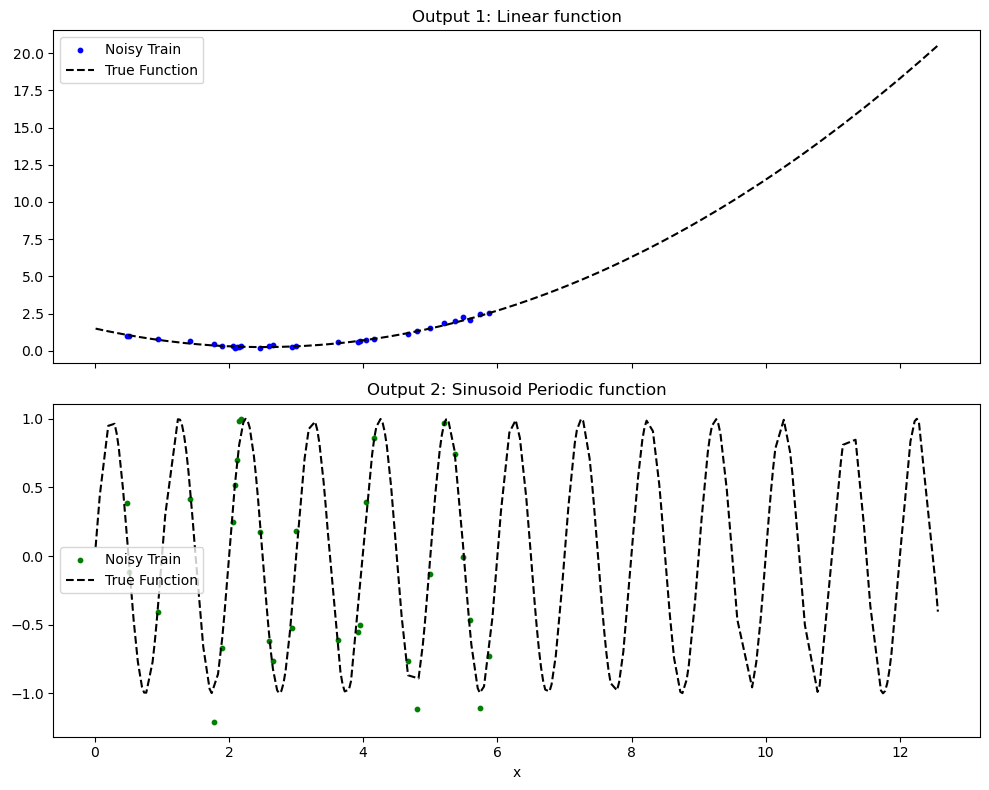

In [483]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].scatter(X_train, y1_train, s=10, color='blue', label='Noisy Train')
axes[0].plot(X_test, y1_test, color='black', linestyle='--', label='True Function')
axes[0].set_title('Output 1: Linear function')
axes[0].legend()

axes[1].scatter(X_train, y2_train, s=10, color='green', label='Noisy Train')
axes[1].plot(X_test, y2_test, color='black', linestyle='--', label='True Function')
axes[1].set_title('Output 2: Sinusoid Periodic function')
axes[1].legend()

plt.xlabel("x")
plt.tight_layout()
plt.show()

In [484]:
X_train

array([[0.47360693],
       [0.50518073],
       [0.94721387],
       [1.4208208 ],
       [1.76813255],
       [1.89442773],
       [2.05229671],
       [2.0838705 ],
       [2.1154443 ],
       [2.14701809],
       [2.17859189],
       [2.46275605],
       [2.58905123],
       [2.65219882],
       [2.93636298],
       [2.99951057],
       [3.63098648],
       [3.91515064],
       [3.94672444],
       [4.04144583],
       [4.16774101],
       [4.67292174],
       [4.79921692],
       [4.98865969],
       [5.20967626],
       [5.36754524],
       [5.49384042],
       [5.58856181],
       [5.74643078],
       [5.87272597]])

In [485]:
# SOGP vs MOGP
# Case1: (SOGP) Func1 using the RBF kernel, Func2 using the periodic kernel
# Case2: (MOGP) Using two kernel: RBF + Periodic combine

## Case1 SOGP

In [487]:
def periodic_kernel(X1, X2, lengthscale, variance, period):
    X_1 = np.atleast_2d(X1).reshape(-1, 1)
    X_2 = np.atleast_2d(X2).reshape(-1, 1)
    dists = np.abs(X1 - X2.T)
    sin_term = np.sin(np.pi * dists / period)
    return variance**2 * np.exp(-2 * (sin_term**2) / lengthscale**2)

def rbf_kernel(X1, X2, lengthscale, variance):
    X1 = np.atleast_2d(X1) # view the array input X as an matrix 2d
    X2 = np.atleast_2d(X2)

    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 * sqdist / lengthscale**2)

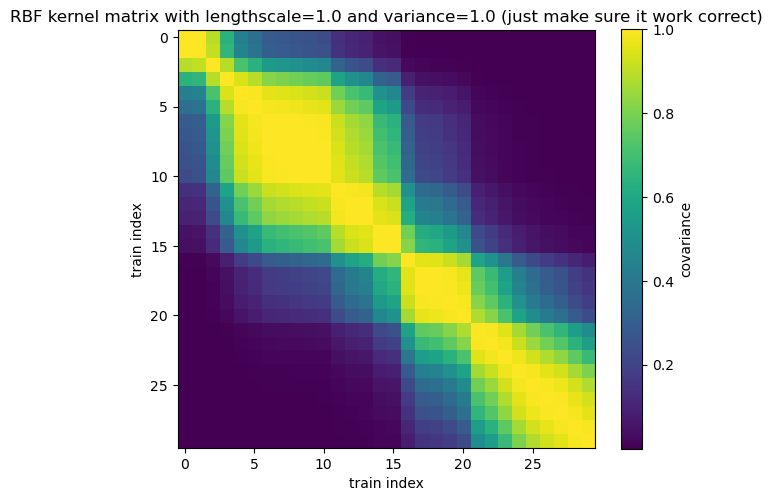

In [488]:
test_rbf = rbf_kernel(X_train, X_train, 1.0, 1.0)
plt.figure(figsize=(6, 5))
plt.imshow(test_rbf, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"RBF kernel matrix with lengthscale=1.0 and variance=1.0 (just make sure it work correct)")
plt.xlabel("train index")
plt.ylabel("train index")
plt.tight_layout()
plt.show()

In [489]:
X_train.shape

(30, 1)

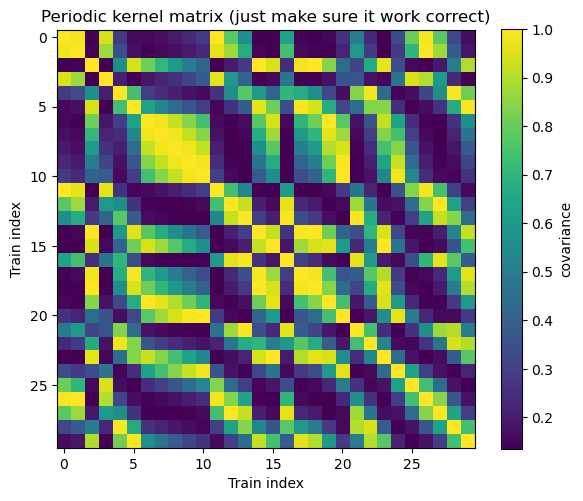

In [490]:
test_rbf = periodic_kernel(X_train, X_train, 1.0, 1.0, 1.0)
plt.figure(figsize=(6, 5))
plt.imshow(test_rbf, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"Periodic kernel matrix (just make sure it work correct)")
plt.xlabel("Train index")
plt.ylabel("Train index")
plt.tight_layout()
plt.show()

In [491]:
# using the rbf kernel for function 1
def nll_rbf(params_rbf, X_train, Y_train):
    #get hyper params value
    sigma_f, length_scale_l, noise = params_rbf
    
    # get the covariance matrix
    K = rbf_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)
    
    # get negative log likelihood
    nll = 0.5 * Y_train.T @ alpha + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2*np.pi)
    return nll.item()

# rbf prediction for the 1st output function
def sogp_rbf_prediction(X_train, X_test, Y_train, optimized_params):
    sigma_f, length_scale_l, noise = optimized_params
    # getting the inverse cov train with cholesky
    K = rbf_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)

    K_s = rbf_kernel(X_train, X_test, lengthscale=length_scale_l, variance=sigma_f)
    #getting the mean: y_test = K_s*K-1*y_train
    mean = K_s.T @ alpha

    K_ss = rbf_kernel(X_test, X_test, lengthscale=length_scale_l, variance=sigma_f)
    v = LA.solve_triangular(L, K_s, lower=True) ## getting the v = L \ K_s
    var = np.diag(K_ss) - np.sum(v**2, axis=0) # getting predict variance
    return mean.ravel(), np.maximum(var, 0)

In [492]:
# periodic kernel and prediction for the others function 
def nll_periodic(params, X_train, Y_train):
    #get hyper params value
    sigma_f, length_scale_l, period_p, noise = params
    
    # get the covariance matrix
    K = periodic_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)
    
    # get negative log likelihood
    nll = 0.5 * Y_train.T @ alpha + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2*np.pi)
    return nll.item()

def sogp_periodic_prediction(X_train, X_test, Y_train, optimized_params):
    sigma_f, length_scale_l, period_p, noise = optimized_params
    # getting the inverse cov train with cholesky
    K = periodic_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)

    K_s = periodic_kernel(X_train, X_test, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    #getting the mean: y_test = K_s*K-1*y_train
    mean = K_s.T @ alpha

    K_ss = periodic_kernel(X_test, X_test, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    v = LA.solve_triangular(L, K_s, lower=True) ## getting the v = L \ K_s
    var = np.diag(K_ss) - np.sum(v**2, axis=0) # getting predict variance
    return mean.ravel(), np.maximum(var, 0)


In [493]:
def run_opt_for_each_output_indep(X_train, Y_train, X_test, Y_test, output_order):
    # differenet optimizer and prediction for each function
    if output_order == 2:
        init_value = [1.0, 1.0, np.pi, 0.1]
        # set the bounds for params
        # bounds = [(0.1, 15.0), (0.1, 10.0), (1.0, 10.0), (1e-3, None)] #order: sigma_f, length_scale, period, noise
        bounds = [(0.1, 5.0), (0.1, 5.0), (0.5, 10.0), (1e-2, None)] #order: sigma_f, length_scale, period, noise
        
        res = opt.minimize(nll_periodic, init_value, args=(X_train, Y_train), method='L-BFGS-B', bounds=bounds)
        
        params_opt = res.x
    
        print(f"Optimized params for output {output_order}: \n {params_opt}")
    
        lml = -res.fun
        print(f"Log Marginal Likelihood of the {output_order}: {lml:.4f}")
    
        mean, var = sogp_periodic_prediction(X_train, X_test, Y_train, params_opt)
        mse = np.mean((mean - Y_test.ravel())**2)
        print(f"Test Mean Square Error for output {output_order}: {mse:.4f}")
    
        return mean, var
    
    else:
        # init_value = [1.0, 0.01, 0.1]
        init_value = [1.0, 1.0, 0.1]
        
        # set the bounds for params of the rbf kernel
        bounds = [(1e-3, None), (1e-3, None), (1e-2, None)] #order: sigma_f, length_scale, noise
        res = opt.minimize(nll_rbf, init_value, args=(X_train, Y_train), method='L-BFGS-B', bounds=bounds)

        params_opt = res.x
    
        print(f"Optimized params for output {output_order}: \n {params_opt}")
    
        lml = -res.fun
        print(f"Log Marginal Likelihood of the {output_order}: {lml:.4f}")
    
        mean, var = sogp_rbf_prediction(X_train, X_test, Y_train, params_opt)
        mse = np.mean((mean - Y_test.ravel())**2)
        print(f"Test Mean Square Error for output {output_order}: {mse:.4f}")
    
        return mean, var

In [494]:
# test the optimize and predict function
print("-------------Output 1--------------")
mu_0, var_0 = run_opt_for_each_output_indep(X_train, y1_train, X_test, y1_test, output_order = 1)

print("-------------Output 2--------------")
mu_1, var_1 = run_opt_for_each_output_indep(X_train, y2_train, X_test, y2_test, output_order = 2)

-------------Output 1--------------
Optimized params for output 1: 
 [1.93928391 1.63340847 0.07017088]
Log Marginal Likelihood of the 1: 19.0056
Test Mean Square Error for output 1: 52.1740
-------------Output 2--------------
Optimized params for output 2: 
 [1.21132071 1.01509376 1.99896024 0.1072069 ]
Log Marginal Likelihood of the 2: 4.1888
Test Mean Square Error for output 2: 0.0024


In [495]:
np.sqrt(var_0)

array([0.15831281, 0.13724438, 0.10043599, 0.07794391, 0.07150309,
       0.06563039, 0.0556959 , 0.04828108, 0.04189812, 0.04038851,
       0.04039032, 0.04075065, 0.04125078, 0.0430211 , 0.04356477,
       0.044042  , 0.04443424, 0.0450077 , 0.04335846, 0.04276628,
       0.04210124, 0.04137351, 0.04058644, 0.03975037, 0.03796674,
       0.03703249, 0.03320987, 0.03044427, 0.02958031, 0.02722591,
       0.02590358, 0.02533012, 0.02436456, 0.02340179, 0.02308501,
       0.02301744, 0.0230716 , 0.02318084, 0.0233418 , 0.02380344,
       0.02409714, 0.02442715, 0.02478814, 0.02517824, 0.02559213,
       0.02602422, 0.02647312, 0.02693337, 0.02739944, 0.02834078,
       0.02880697, 0.02926388, 0.02971096, 0.03014345, 0.03095116,
       0.03132207, 0.0319834 , 0.03293763, 0.03321084, 0.0333599 ,
       0.03334221, 0.03329277, 0.0331061 , 0.03297295, 0.03281673,
       0.03157384, 0.03134874, 0.0311273 , 0.03071124, 0.03052346,
       0.02978437, 0.02982808, 0.02988816, 0.03004794, 0.03014

In [496]:
mu_0

array([1.07060252e+00, 1.07236237e+00, 1.06676504e+00, 1.05456288e+00,
       1.04898236e+00, 1.04265879e+00, 1.02784909e+00, 1.01021541e+00,
       9.78695794e-01, 9.54599704e-01, 9.28228467e-01, 9.14231868e-01,
       8.99745372e-01, 8.53698284e-01, 8.37611513e-01, 8.21142198e-01,
       8.04375350e-01, 7.52698360e-01, 6.46177973e-01, 6.28423043e-01,
       6.10770135e-01, 5.93310167e-01, 5.75966807e-01, 5.58830165e-01,
       5.25362295e-01, 5.09041866e-01, 4.47486303e-01, 4.05802251e-01,
       3.92941050e-01, 3.57513691e-01, 3.36726866e-01, 3.27256820e-01,
       3.10086368e-01, 2.89008130e-01, 2.78081005e-01, 2.69618322e-01,
       2.66315590e-01, 2.63604642e-01, 2.61488204e-01, 2.58999881e-01,
       2.58600735e-01, 2.58749622e-01, 2.59429506e-01, 2.60629953e-01,
       2.62334175e-01, 2.64518441e-01, 2.67180250e-01, 2.70296622e-01,
       2.73838590e-01, 2.82188084e-01, 2.86950913e-01, 2.92066508e-01,
       2.97551068e-01, 3.03372892e-01, 3.15946271e-01, 3.22689017e-01,
      

In [497]:
### plot the prediction
std_0 = np.sqrt(var_0)
std_1 = np.sqrt(var_1)

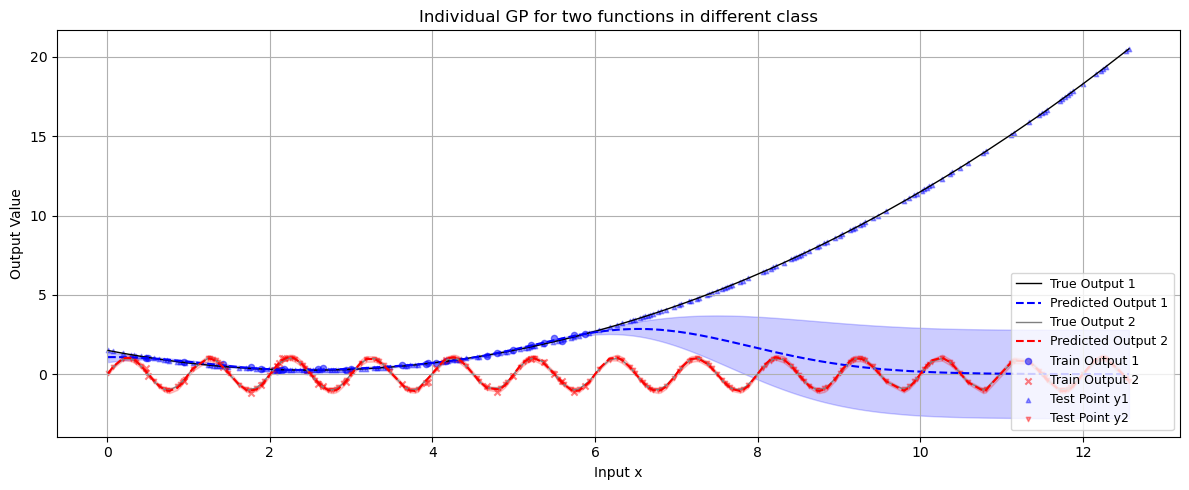

In [498]:
# plot predictions and uncertainties with training and test points highlighted
fig, ax = plt.subplots(figsize=(12, 5))

X_train_flat = X_train.flatten()
X_test_flat = X_test.flatten()

# plot true and predicted for output 1
ax.plot(X_test, y1_test, label="True Output 1", color="black", linewidth=1)
ax.plot(X_test, mu_0, label="Predicted Output 1", linestyle="--", color="blue")
ax.fill_between(X_test_flat,
                mu_0 - 2 * std_0,
                mu_0 + 2 * std_0,
                color="blue", alpha=0.2)

# plot true and predicted for output 2
ax.plot(X_test, y2_test, label="True Output 2", color="gray", linewidth=1)
ax.plot(X_test, mu_1, label="Predicted Output 2", linestyle="--", color="red")
ax.fill_between(X_test_flat,
                mu_1 - 2 * std_1,
                mu_1 + 2 * std_1,
                color="red", alpha=0.2)

# training points
ax.scatter(X_train, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X_train, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')

# test points (without noise)
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point y1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point y2", alpha=0.4, marker='v')

# settings
ax.set_title("Individual GP for two functions in different class")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()

## Using the MOGP with SLFM approach for modeling these function

In [500]:
# !pip install GPy

In [501]:
import GPy

X1 = X_train.copy()                          # (N, 1)
Y1 = y1_train.reshape(-1, 1)

X2 = X_train.copy()
Y2 = y2_train.reshape(-1, 1)

X_list = [X1, X2]
Y_list = [Y1, Y2]

In [502]:
from GPy.util.multioutput import LCM

kern_list = []

# for _ in range(2):  # 2 latent functions
#     # define SE and Periodic components
#     k_se = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
#     k_per = GPy.kern.StdPeriodic(input_dim=1, variance=1.0, lengthscale=1.0, period=np.pi)
    
#     # apply constraints to keep optimization stable
#     k_se.variance.constrain_bounded(1e-3, 15.0)
#     k_se.lengthscale.constrain_bounded(1e-3, 15.0)

#     kern_list.append(k_se)

#     k_per.variance.constrain_bounded(0.1, 5.0)
#     k_per.lengthscale.constrain_bounded(0.1, 5.0)
#     k_per.period.constrain_bounded(0.5, 10.0)
    
#     kern_list.append(k_per)

k_se = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)
k_se.variance.constrain_bounded(1e-3, 15.0)
k_se.lengthscale.constrain_bounded(1e-3, 15.0)
kern_list.append(k_se)

k_per = GPy.kern.StdPeriodic(1, variance=1.0, lengthscale=1.0, period=np.pi)
k_per.variance.constrain_bounded(0.1, 5.0)
k_per.lengthscale.constrain_bounded(0.1, 5.0)
k_per.period.constrain_bounded(0.5, 10.0)
kern_list.append(k_per)

# Construct the LCM (Linear Coregionalization Model) kernel
lcm_kernel = LCM(input_dim=1, num_outputs=2, kernels_list=kern_list)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.period


In [503]:
## Using linear kernel + period kernel for modeling two functions that totally different
# kern_list = []
# for _ in range(2):  # 2 latent functions
#     # Define Linear and Periodic components
#     k_lin = GPy.kern.Linear(input_dim=1, variances=1.0)
#     k_per = GPy.kern.StdPeriodic(input_dim=1, variance=1.0, lengthscale=1.0, period=np.pi)
    
#     # Apply constraints to keep optimization stable
#     k_lin.variances.constrain_bounded(1e-3, 15.0)

#     k_per.variance.constrain_bounded(1e-3, 15.0)
#     k_per.lengthscale.constrain_bounded(0.1, 5.0)
#     k_per.period.constrain_bounded(0.5, 10.0)

#     # Combine into one kernel per latent function
#     kern_list.append(k_lin + k_per)

# # Construct the Linear Coregionalization Model (LCM) kernel
# lcm_kernel = LCM(input_dim=1, num_outputs=2, kernels_list=kern_list)

In [504]:
model = GPy.models.GPCoregionalizedRegression(X_list=X_list, Y_list=Y_list, kernel=lcm_kernel)
model['.*Gaussian_noise'] = 0.01
model['.*Gaussian_noise'].fix()
model.optimize_restarts(num_restarts=5, verbose=False)

In [505]:
# model = GPy.models.GPCoregionalizedRegression(X_list, Y_list, kernel=lcm_kernel)
# model.optimize(messages=True)

In [506]:
# Create test sets with index 0 and 1
Xtest_0 = np.hstack([X_test, np.zeros_like(X_test)])
Xtest_1 = np.hstack([X_test, np.ones_like(X_test)])

# Create metadata
Y_metadata_0 = {'output_index': np.zeros((X_test.shape[0], 1), dtype=int)}
Y_metadata_1 = {'output_index': np.ones((X_test.shape[0], 1), dtype=int)}

# Predict with metadata
mu_0, var_0 = model.predict(Xtest_0, Y_metadata=Y_metadata_0)
mu_1, var_1 = model.predict(Xtest_1, Y_metadata=Y_metadata_1)

In [507]:
from sklearn.metrics import mean_squared_error

mse_0 = mean_squared_error(y1_test, mu_0)
mse_1 = mean_squared_error(y2_test, mu_1)
lml_lib = model.log_likelihood()


In [508]:
print("MSE output 1:", mse_0)
print("MSE output 2:", mse_1)
print("Log Marginal Likelihood:", lml_lib)

MSE output 1: 21.71346038365599
MSE output 2: 0.002118970669600635
Log Marginal Likelihood: 32.04095973126131


In [509]:
model.sum

sum.,value,constraints,priors
ICM0.rbf.variance,0.2542328691648679,"0.001,15.0",
ICM0.rbf.lengthscale,4.452801927684743,"0.001,15.0",
ICM0.B.W,"(2, 1)",,
ICM0.B.kappa,"(2,)",+ve,
ICM1.std_periodic.variance,0.10000781484290662,"0.1,5.0",
ICM1.std_periodic.period,0.9996410036040535,"0.5,10.0",
ICM1.std_periodic.lengthscale,5.0,"0.1,5.0",
ICM1.B.W,"(2, 1)",,
ICM1.B.kappa,"(2,)",+ve,


In [510]:
A1 = model.sum.ICM0.B.W
A2 = model.sum.ICM1.B.W

In [511]:
A1

index,gp.sum.ICM0.B.W,constraints,priors
[0 0],7.33033749,,
[1 0],0.02009186,,


In [512]:
A2

index,gp.sum.ICM1.B.W,constraints,priors
[0 0],0.01357062,,
[1 0],-20.29161462,,


In [513]:
std_0 = np.sqrt(var_0)
std_1 = np.sqrt(var_1)

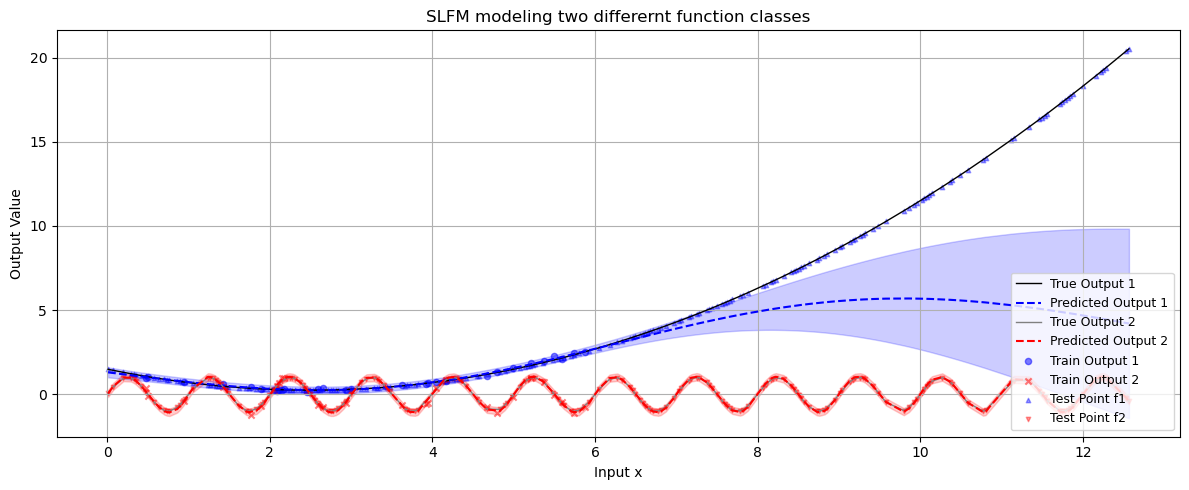

In [514]:
# plot predictions and uncertainties with training and test points highlighted
fig, ax = plt.subplots(figsize=(12, 5))

X_train_flat = X_train.flatten()
X_test_flat = X_test.flatten()

# plot true and predicted for Output 1
ax.plot(X_test, y1_test, label="True Output 1", color="black", linewidth=1)
ax.plot(X_test, mu_0[:,0], label="Predicted Output 1", linestyle="--", color="blue")
ax.fill_between(X_test_flat,
                mu_0[:,0] - 2 * std_0[:,0],
                mu_0[:,0] + 2 * std_0[:,0],
                color="blue", alpha=0.2)

# plot true and predicted for Output 2
ax.plot(X_test, y2_test, label="True Output 2", color="gray", linewidth=1)
ax.plot(X_test, mu_1[:,0], label="Predicted Output 2", linestyle="--", color="red")
ax.fill_between(X_test_flat,
                mu_1[:,0] - 2 * std_1[:,0],
                mu_1[:,0] + 2 * std_1[:,0],
                color="red", alpha=0.2)

# training points
ax.scatter(X_train, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X_train, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')

# test points (without noise)
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point f1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point f2", alpha=0.4, marker='v')

# settings
ax.set_title("SLFM modeling two differernt function classes")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()


## Missing value cases

In [516]:
missing_ratio = 0.5
n_missing = int(missing_ratio * len(y2_train))
missing_idx = np.random.choice(len(y2_train), size=n_missing, replace=False)

y2_train_missing = y2_train.copy()
y2_train_missing[missing_idx] = np.nan

X2_obs = X_train[~np.isnan(y2_train_missing).flatten()]
y2_obs = y2_train_missing[~np.isnan(y2_train_missing).flatten()]

X_list = [X_train.copy(), X2_obs]
Y_list = [y1_train.copy(), y2_obs]



In [517]:
#define the rbf

from GPy.util.multioutput import LCM

kern_list = []

k_se = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)
k_se.variance.constrain_bounded(1e-3, 15.0)
k_se.lengthscale.constrain_bounded(1e-3, 15.0)
kern_list.append(k_se)

k_per = GPy.kern.StdPeriodic(1, variance=1.0, lengthscale=1.0, period=np.pi)
k_per.variance.constrain_bounded(0.1, 5.0)
k_per.lengthscale.constrain_bounded(0.1, 5.0)
k_per.period.constrain_bounded(0.5, 10.0)
kern_list.append(k_per)

lcm_kernel = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=kern_list)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.period


In [518]:
model = GPy.models.GPCoregionalizedRegression(X_list=X_list, Y_list=Y_list, kernel=lcm_kernel)
model['.*Gaussian_noise'] = 0.01
model['.*Gaussian_noise'].fix()
model.optimize_restarts(num_restarts=5, verbose=False)

In [519]:
X_test1 = np.hstack([X_test, np.zeros_like(X_test)])
X_test2 = np.hstack([X_test, np.ones_like(X_test)])

task_0 = np.zeros(X_test.shape[0], dtype=int)
task_1 = np.ones(X_test.shape[0], dtype=int)

mu1, var1 = model.predict(X_test1, Y_metadata={'output_index': task_0})
mu2, var2 = model.predict(X_test2, Y_metadata={'output_index': task_1})


mse1 = mean_squared_error(y1_test, mu1)
mse2 = mean_squared_error(y2_test, mu2)


X_missing_y2 = X_train[missing_idx]
X_missing_y2_tagged = np.hstack([X_missing_y2, np.ones_like(X_missing_y2)])
task_miss = np.ones(X_missing_y2.shape[0], dtype=int)
mu_miss_y2, _ = model.predict(X_missing_y2_tagged, Y_metadata={'output_index': task_miss})
mse_miss = mean_squared_error(y2_train[missing_idx], mu_miss_y2)

In [520]:
print("Optimized Parameters in missing randomly cases:")
print(model)

print("----------------------------------------------")

print("Log Marginal Likelihood in missing randomly cases")
print(model.log_likelihood())

print("----------------------------------------------")

print("Mixing Matrix A in missing randomly cases")
for i, part in enumerate(model.kern.parts):  # each part is Prod(kernel, coregion)
    A_i = part.parts[1].W  # access coregion.W
    print(f"Latent {i}: A =\n{A_i}")

print(f"\nTest MSE - Output 1 (f1): {mse1:.4f}")
print(f"Test MSE - Output 2 (f2): {mse2:.4f}")
print(f"MSE on Missing Predictions (Output 2): {mse_miss:.4f}")

Optimized Parameters in missing randomly cases:

Name : gp
Objective : -15.06967625842432
Number of Parameters : 15
Number of Optimization Parameters : 13
Updates : True
Parameters:
  gp.                                    |                  value  |  constraints  |  priors
  sum.ICM0.rbf.variance                  |  0.0010000000081826744  |  0.001,15.0   |        
  sum.ICM0.rbf.lengthscale               |      4.461112144892186  |  0.001,15.0   |        
  sum.ICM0.B.W                           |                 (2, 1)  |               |        
  sum.ICM0.B.kappa                       |                   (2,)  |      +ve      |        
  sum.ICM1.std_periodic.variance         |                    0.1  |    0.1,5.0    |        
  sum.ICM1.std_periodic.period           |      1.989100452623503  |   0.5,10.0    |        
  sum.ICM1.std_periodic.lengthscale      |     0.3588819086982743  |    0.1,5.0    |        
  sum.ICM1.B.W                           |                 (2, 1)  |      

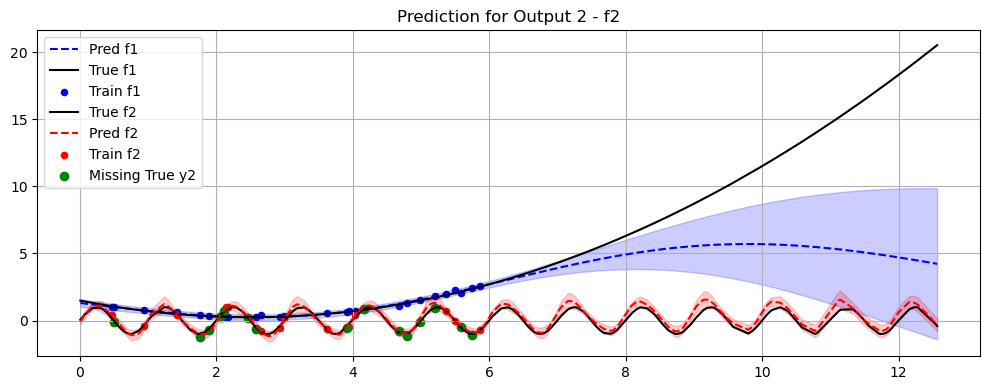

In [521]:
# plot output 1
plt.figure(figsize=(10, 4))
plt.title("SLFM Prediction for Output 1 - f1")
plt.fill_between(X_test.flatten(), mu1.flatten() - 2*np.sqrt(var1.flatten()), mu1.flatten() + 2*np.sqrt(var1.flatten()), color='blue', alpha=0.2)
plt.plot(X_test, mu1, 'b--', label="Pred f1")
plt.plot(X_test, y1_test, 'k-', label="True f1")
plt.scatter(X_train, y1_train, color='blue', s=20, label="Train f1")

plt.title("Prediction for Output 2 - f2")
plt.fill_between(X_test.flatten(), mu2.flatten() - 2*np.sqrt(var2.flatten()), mu2.flatten() + 2*np.sqrt(var2.flatten()), color='red', alpha=0.2)
plt.plot(X_test, y2_test, 'k-', label="True f2")
plt.plot(X_test, mu2, 'r--', label="Pred f2")
plt.scatter(X_train[~np.isnan(y2_train_missing.flatten())], y2_train_missing[~np.isnan(y2_train_missing.flatten())], color='red', s=20, label="Train f2")
plt.scatter(X_train[missing_idx], y2_train[missing_idx], color='green', label="Missing True y2")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Missing in the middle part

In [523]:
def apply_missing_middle(X, y2):
    N = len(X)
    y2_missing = y2.copy()
    start = N // 3
    end = 2 * N // 3
    y2_missing[start:end] = np.nan
    return y2_missing, np.arange(start, end)

y2_train_missing, missing_idx = apply_missing_middle(X_train, y2_train)

In [524]:
X1 = X_train.copy()
X2 = X_train.copy()

Y1 = y1_train.copy()
Y2 = y2_train_missing.copy()

X_list_filtered, Y_list_filtered = [], []
for x_i, y_i in zip([X1, X2], [Y1, Y2]):
    mask = ~np.isnan(y_i.flatten())
    X_list_filtered.append(x_i[mask])
    Y_list_filtered.append(y_i[mask])

In [525]:
from GPy.util.multioutput import LCM
kern_list = []

k1 = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)
k1.variance.constrain_bounded(1e-3, 15.0)
k1.lengthscale.constrain_bounded(1e-3, 15.0)
kern_list.append(k1)

k2 = GPy.kern.StdPeriodic(1, variance=1.0, lengthscale=1.0, period=np.pi)
k2.variance.constrain_bounded(0.1, 5.0)
k2.lengthscale.constrain_bounded(0.1, 5.0)
k2.period.constrain_bounded(0.5, 10.0)
kern_list.append(k2)

lcm_kernel = LCM(input_dim=1, num_outputs=2, kernels_list=kern_list)
model = GPy.models.GPCoregionalizedRegression(X_list_filtered, Y_list_filtered, kernel=lcm_kernel)
model['.*Gaussian_noise'] = 0.01
model['.*Gaussian_noise'].fix()
model.optimize_restarts(5, verbose=False)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.period


In [526]:
X_test1 = np.hstack([X_test, np.zeros_like(X_test)])
X_test2 = np.hstack([X_test, np.ones_like(X_test)])
mu1, var1 = model.predict(X_test1, Y_metadata={'output_index': np.zeros(X_test.shape[0], dtype=int)})
mu2, var2 = model.predict(X_test2, Y_metadata={'output_index': np.ones(X_test.shape[0], dtype=int)})

X_miss = X_train[missing_idx]
X_miss_input = np.hstack([X_miss, np.ones_like(X_miss)])
mu_miss, _ = model.predict(X_miss_input, Y_metadata={'output_index': np.ones(X_miss.shape[0], dtype=int)})

mse_test1 = mean_squared_error(y1_test, mu1)
mse_test2 = mean_squared_error(y2_test, mu2)
mse_missing = mean_squared_error(y2_train[missing_idx], mu_miss)
nll = model.log_likelihood()

print("=== Optimized Hyperparameters case missing output at the middle ===")
print(model)

print("=== Mixing Matrix A per Latent case missing output at the middle ===")
for i, part in enumerate(model.kern.parts):
    print(f"Latent {i}:\n", part.parts[1].W)

print(f"\nMSE Test Output 1: {mse_test1:.4f}")
print(f"MSE Test Output 2: {mse_test2:.4f}")
print(f"MSE on Missing Region (y2): {mse_missing:.4f}")
print(f"Negative Log Marginal Likelihood: {nll:.4f}")

=== Optimized Hyperparameters case missing output at the middle ===

Name : gp
Objective : -11.991845431961718
Number of Parameters : 15
Number of Optimization Parameters : 13
Updates : True
Parameters:
  gp.                                    |                 value  |  constraints  |  priors
  sum.ICM0.rbf.variance                  |  0.047535837832477126  |  0.001,15.0   |        
  sum.ICM0.rbf.lengthscale               |     4.457052586375689  |  0.001,15.0   |        
  sum.ICM0.B.W                           |                (2, 1)  |               |        
  sum.ICM0.B.kappa                       |                  (2,)  |      +ve      |        
  sum.ICM1.std_periodic.variance         |    0.1000003072068969  |    0.1,5.0    |        
  sum.ICM1.std_periodic.period           |    3.0160823697056505  |   0.5,10.0    |        
  sum.ICM1.std_periodic.lengthscale      |    0.2860300849643972  |    0.1,5.0    |        
  sum.ICM1.B.W                           |                (2,

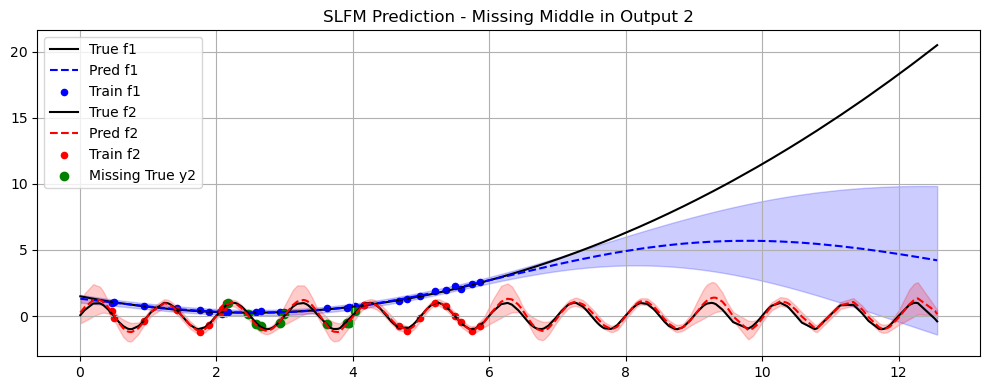

In [527]:
plt.figure(figsize=(10, 4))
plt.title("SLFM Prediction - Missing Middle in Output 2")
plt.fill_between(X_test.flatten(), mu1.flatten() - 2*np.sqrt(var1.flatten()), mu1.flatten() + 2*np.sqrt(var1.flatten()), color='blue', alpha=0.2)
plt.plot(X_test, y1_test, 'k-', label="True f1")
plt.plot(X_test, mu1, 'b--', label="Pred f1")
plt.scatter(X_train, y1_train, color='blue', s=20, label="Train f1")

plt.fill_between(X_test.flatten(), mu2.flatten() - 2*np.sqrt(var2.flatten()), mu2.flatten() + 2*np.sqrt(var2.flatten()), color='red', alpha=0.2)
plt.plot(X_test, y2_test, 'k-', label="True f2")
plt.plot(X_test, mu2, 'r--', label="Pred f2")
plt.scatter(X_train[~np.isnan(y2_train_missing.flatten())], y2_train_missing[~np.isnan(y2_train_missing.flatten())], color='red', s=20, label="Train f2")
plt.scatter(X_train[missing_idx], y2_train[missing_idx], color='green', label="Missing True y2")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Missing at the beginning

In [529]:
def apply_missing_beginning(X, y2):
    N = len(X)
    cut = N // 3
    y2_missing = y2.copy()
    y2_missing[:cut] = np.nan
    return y2_missing, np.arange(0, cut)

y2_train_missing, missing_idx = apply_missing_beginning(X_train, y2_train)

In [530]:

X_list_filtered, Y_list_filtered = [], []
for x_i, y_i in zip([X_train, X_train], [y1_train, y2_train_missing]):
    mask = ~np.isnan(y_i.flatten())
    X_list_filtered.append(x_i[mask])
    Y_list_filtered.append(y_i[mask])

In [531]:
kern_list = []

k1 = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)
k1.variance.constrain_bounded(1e-3, 15.0)
k1.lengthscale.constrain_bounded(1e-3, 15.0)
kern_list.append(k1)

k2 = GPy.kern.StdPeriodic(1, variance=1.0, lengthscale=1.0, period=np.pi)
k2.variance.constrain_bounded(0.1, 5.0)
k2.lengthscale.constrain_bounded(0.1, 5.0)
k2.period.constrain_bounded(0.5, 10.0)
kern_list.append(k2)

lcm_kernel = LCM(input_dim=1, num_outputs=2, kernels_list=kern_list)
model = GPy.models.GPCoregionalizedRegression(X_list_filtered, Y_list_filtered, kernel=lcm_kernel)
model['.*Gaussian_noise'] = 0.01
model['.*Gaussian_noise'].fix()
model.optimize_restarts(5, verbose=False)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.period


In [532]:
X_test1 = np.hstack([X_test, np.zeros_like(X_test)])
X_test2 = np.hstack([X_test, np.ones_like(X_test)])
mu1, var1 = model.predict(X_test1, Y_metadata={'output_index': np.zeros(X_test.shape[0], dtype=int)})
mu2, var2 = model.predict(X_test2, Y_metadata={'output_index': np.ones(X_test.shape[0], dtype=int)})

X_miss = X_train[missing_idx]
X_miss_input = np.hstack([X_miss, np.ones_like(X_miss)])
mu_miss, _ = model.predict(X_miss_input, Y_metadata={'output_index': np.ones(X_miss.shape[0], dtype=int)})

mse_test1 = mean_squared_error(y1_test, mu1)
mse_test2 = mean_squared_error(y2_test, mu2)
mse_missing = mean_squared_error(y2_train[missing_idx], mu_miss)
nll = model.log_likelihood()

print("=== Optimized Hyperparameters in case missing output at the beginning ===")
print(model)

print("=== Mixing Matrix A per Latent in case missing output at the beginning ===")
for i, part in enumerate(model.kern.parts):
    print(f"Latent {i}:\n", part.parts[1].W)

print(f"\nMSE Test Output 1: {mse_test1:.4f}")
print(f"MSE Test Output 2: {mse_test2:.4f}")
print(f"MSE on Missing Region (y2): {mse_missing:.4f}")
print(f"Negative Log Marginal Likelihood: {nll:.4f}")

=== Optimized Hyperparameters in case missing output at the beginning ===

Name : gp
Objective : -12.932305814668236
Number of Parameters : 15
Number of Optimization Parameters : 13
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  sum.ICM0.rbf.variance                  |  0.06427009532010616  |  0.001,15.0   |        
  sum.ICM0.rbf.lengthscale               |    4.453431137790215  |  0.001,15.0   |        
  sum.ICM0.B.W                           |               (2, 1)  |               |        
  sum.ICM0.B.kappa                       |                 (2,)  |      +ve      |        
  sum.ICM1.std_periodic.variance         |  0.10000000001117161  |    0.1,5.0    |        
  sum.ICM1.std_periodic.period           |    2.999768741797215  |   0.5,10.0    |        
  sum.ICM1.std_periodic.lengthscale      |  0.23540140586293998  |    0.1,5.0    |        
  sum.ICM1.B.W                           |               (2, 1)

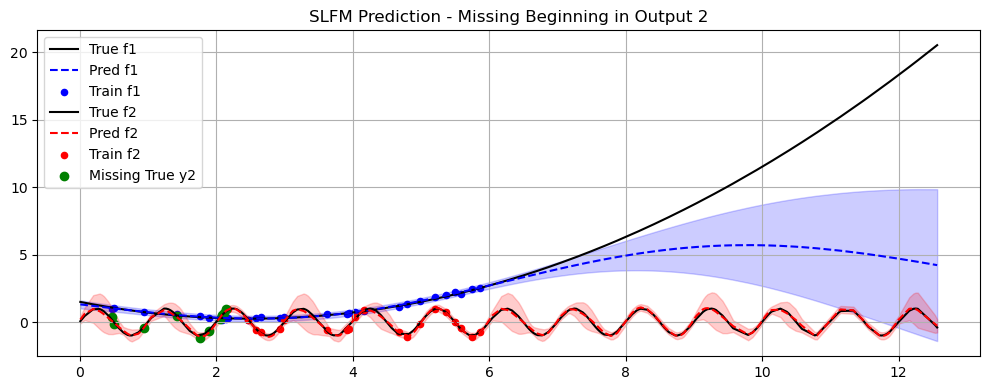

In [533]:
plt.figure(figsize=(10, 4))
plt.title("SLFM Prediction - Missing Beginning in Output 2")
plt.fill_between(X_test.flatten(), mu1.flatten() - 2*np.sqrt(var1.flatten()), mu1.flatten() + 2*np.sqrt(var1.flatten()), color='blue', alpha=0.2)
plt.plot(X_test, y1_test, 'k-', label="True f1")
plt.plot(X_test, mu1, 'b--', label="Pred f1")
plt.scatter(X_train, y1_train, color='blue', s=20, label="Train f1")

plt.fill_between(X_test.flatten(), mu2.flatten() - 2*np.sqrt(var2.flatten()), mu2.flatten() + 2*np.sqrt(var2.flatten()), color='red', alpha=0.2)
plt.plot(X_test, y2_test, 'k-', label="True f2")
plt.plot(X_test, mu2, 'r--', label="Pred f2")
plt.scatter(X_train[~np.isnan(y2_train_missing.flatten())], y2_train_missing[~np.isnan(y2_train_missing.flatten())], color='red', s=20, label="Train f2")
plt.scatter(X_train[missing_idx], y2_train[missing_idx], color='green', label="Missing True y2")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()